device: cpu
epochs: 20
batchsize: 100
visualization interval: 1



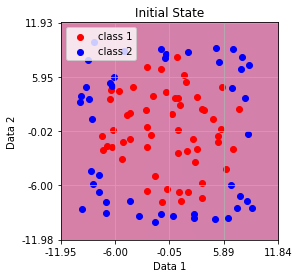

Epoch 1
  train loss = 0.7272
  accuracy = 67.34%


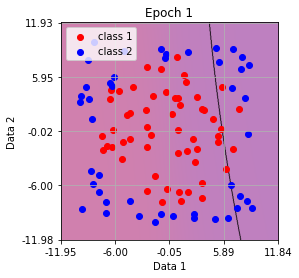


Epoch 2
  train loss = 0.6776
  accuracy = 53.77%


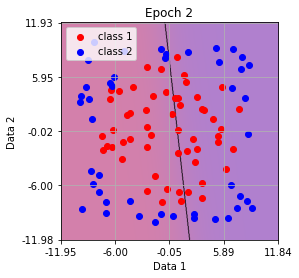


Epoch 3
  train loss = 0.6327
  accuracy = 56.28%


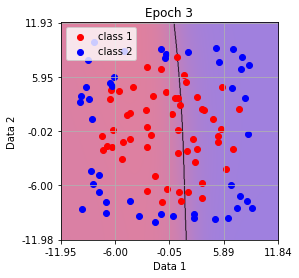


Epoch 4
  train loss = 0.6175
  accuracy = 62.31%


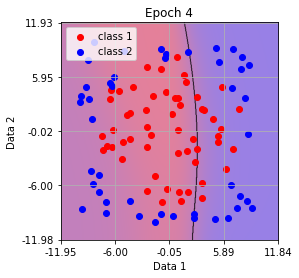


Epoch 5
  train loss = 0.6131
  accuracy = 72.86%


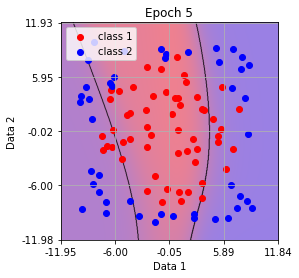


Epoch 6
  train loss = 0.6072
  accuracy = 76.38%


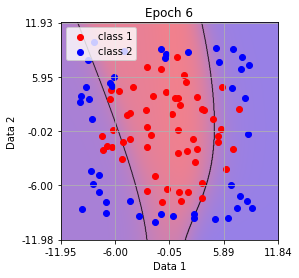


Epoch 7
  train loss = 0.6045
  accuracy = 75.88%


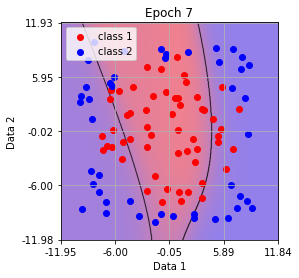


Epoch 8
  train loss = 0.5957
  accuracy = 75.38%


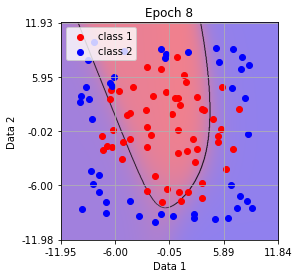


Epoch 9
  train loss = 0.5953
  accuracy = 76.38%


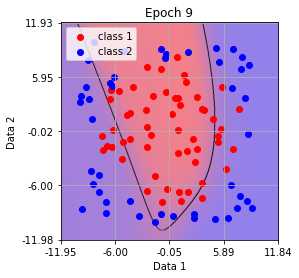


Epoch 10
  train loss = 0.5820
  accuracy = 76.88%


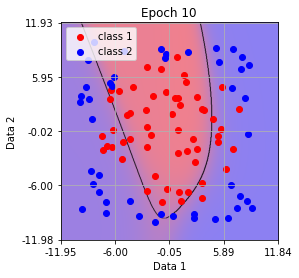


Epoch 11
  train loss = 0.5783
  accuracy = 79.40%


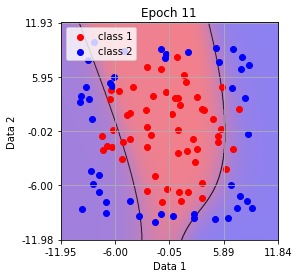


Epoch 12
  train loss = 0.5688
  accuracy = 78.39%


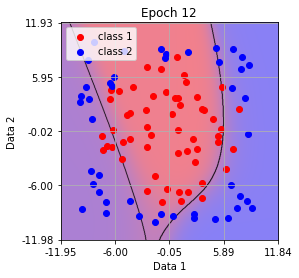


Epoch 13
  train loss = 0.5711
  accuracy = 75.38%


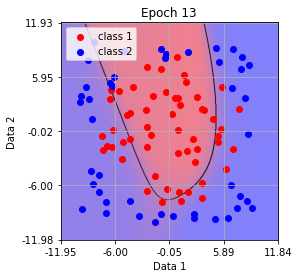


Epoch 14
  train loss = 0.5688
  accuracy = 77.89%


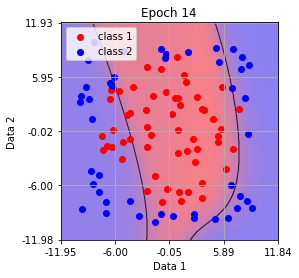


Epoch 15
  train loss = 0.5608
  accuracy = 76.88%


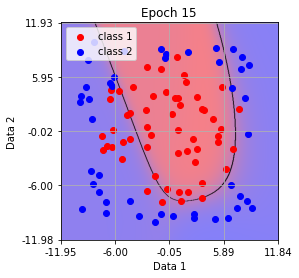


Epoch 16
  train loss = 0.5555
  accuracy = 78.89%


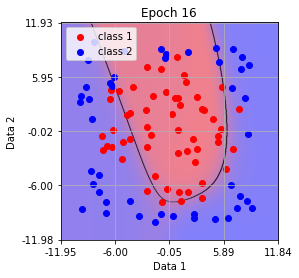


Epoch 17
  train loss = 0.5530
  accuracy = 77.89%


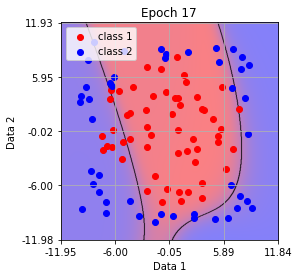


Epoch 18
  train loss = 0.5517
  accuracy = 79.90%


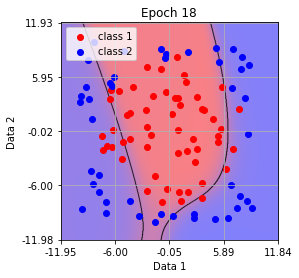


Epoch 19
  train loss = 0.5469
  accuracy = 80.40%


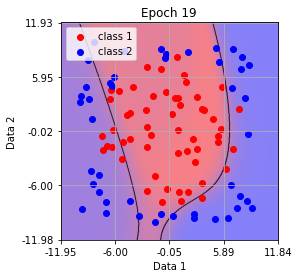


Epoch 20
  train loss = 0.5565
  accuracy = 79.90%


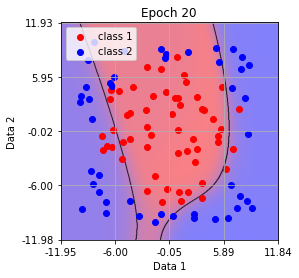

In [2]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from unit_layers import Conv, DownConv, UpConv, Pool, FC, GlobalPool, Flatten, Reshape
from unit_layers import ResBlockP as ResBlock
from visualizers import BCVisualizer
from data_io import read_diamond_data, read_height_weight_data, read_artificial_data, unbias, split


#DATASET_NAME = 'DIAMONDS'
#DATASET_NAME = 'HEIGHT_WEIGHT'
DATASET_NAME = 'ARTIFICIAL'


# 多層パーセプトロンのサンプルコード
# 認識対象のクラスの数は 2 で固定とする
class myMLP(nn.Module):

    # コンストラクタ
    #   - Z: 入力特徴量の次元数
    def __init__(self, Z):
        super(myMLP, self).__init__()

        # ネットワーク構造
        self.layers = nn.Sequential(

            FC(in_units=Z, out_units=3, activation=torch.tanh),
            FC(in_units=3, out_units=2, activation=torch.tanh),
            FC(in_units=2, out_units=2, activation=torch.tanh),
            FC(in_units=2, out_units=2, activation=None)

        )

    # 順伝播
    #   - x: 入力特徴量（ミニバッチ）
    def forward(self, x):
        h = self.layers(x)
        return F.softmax(h, dim=1) - 0.5 # 可視化の都合上，少し特殊な処理を加える


# エントリポイント
if __name__ == '__main__':

    # オプション情報
    gpu_id = -1 # GPU番号（負の値の時はCPUモードで動作する）
    epochs = 20 # 総エポック数（繰り返し回数）
    batchsize = 100 # バッチサイズ
    visualization_interval = 1 # 何エポックごとに可視化結果を表示するか

    # デバイスの設定
    dev_str = 'cuda:{0}'.format(gpu_id) if torch.cuda.is_available() and gpu_id >= 0 else 'cpu'
    dev = torch.device(dev_str)

    # オプション情報の表示
    print('device: {0}'.format(dev_str), file=sys.stderr)
    print('epochs: {0}'.format(epochs), file=sys.stderr)
    print('batchsize: {0}'.format(batchsize), file=sys.stderr)
    print('visualization interval: {0}'.format(visualization_interval), file=sys.stderr)
    print('', file=sys.stderr)

    # ダイアモンドの事例データの読み込み
    if DATASET_NAME == 'DIAMONDS':
        labels, features = read_diamond_data('diamonds.csv') # ダイアモンド事例データの読み込み
    elif DATASET_NAME == 'HEIGHT_WEIGHT':
        labels, features = read_height_weight_data('height_weight.csv') # 身長・体重事例データの読み込み
    elif DATASET_NAME == 'ARTIFICIAL':
        labels, features = read_artificial_data('artificial.csv') # 合成データの読み込み
    features, labels = unbias(features, labels)
    feat_train, feat_valid, lab_train, lab_valid = split(features, labels, ratio=0.1) # データを学習用と検証用に分割
    lab_train = np.asarray(lab_train, dtype=np.int32)
    lab_valid = np.asarray(lab_valid, dtype=np.int32)
    feat_train = np.asarray(feat_train, dtype=np.float32)
    feat_valid = np.asarray(feat_valid, dtype=np.float32)
    n_samples_train = feat_train.shape[0] # 学習データの総数
    n_samples_valid = feat_valid.shape[0] # 評価用データの総数
    n_dims = feat_train.shape[1] # データの次元数
    n_classes = len(np.unique(lab_train)) # クラス数
    del features
    del labels

    # 二クラス識別器の作成
    model = myMLP(n_dims)
    model = model.to(dev)

    # 可視化の準備
    NUM = 100 # 可視化結果に重畳する実データの数
    a = np.min(feat_valid, axis=0)
    b = np.max(feat_valid, axis=0)
    perm = np.random.permutation(n_samples_valid)
    hrange = ((11 * a[0] - b[0]) / 10, (11 * b[0] - a[0]) / 10) # 可視化結果における横軸の範囲
    vrange = ((11 * a[1] - b[1]) / 10, (11 * b[1] - a[1]) / 10) # 可視化結果における縦軸の範囲
    data = [lab_valid[perm[ : NUM]], feat_valid[perm[ : NUM]]] # 可視化結果に重畳する実データ（評価用データからランダムに NUM 個を選択）
    if DATASET_NAME == 'DIAMONDS':
        visualizer_hlabel = 'Carat'
        visualizer_vlabel = 'Price (x100)'
        visualizer_clabels = ['IF', 'SI2']
    elif DATASET_NAME == 'HEIGHT_WEIGHT':
        visualizer_hlabel = 'Height (cm)'
        visualizer_vlabel = 'Weight (kg)'
        visualizer_clabels = ['Female', 'Male']
    elif DATASET_NAME == 'ARTIFICIAL':
        visualizer_hlabel = 'Data 1'
        visualizer_vlabel = 'Data 2'
        visualizer_clabels = ['class 1', 'class 2']
    visualizer = BCVisualizer(hrange=hrange, vrange=vrange, hlabel=visualizer_hlabel, vlabel=visualizer_vlabel, clabels=visualizer_clabels)

    # 初期状態の可視化
    if visualization_interval > 0:
        visualizer.show(model, device=dev, samples=data, title='Initial State') # グラフを表示

    # 損失関数の定義
    loss_func = nn.CrossEntropyLoss() # softmax cross entropy

    # オプティマイザーの用意
    optimizer = optim.Adam(model.parameters())

    # 学習処理ループ
    for e in range(epochs):

        # 現在のエポック番号を表示
        print('Epoch {0}'.format(e + 1), file=sys.stderr)

        # 損失関数の値が小さくなるように識別器のパラメータを更新
        model.train()
        perm = np.random.permutation(n_samples_train)
        sum_loss = 0
        for i in range(0, n_samples_train, batchsize):
            model.zero_grad()
            x = torch.tensor(feat_train[perm[i : i + batchsize]], device=dev)
            t = torch.tensor(lab_train[perm[i : i + batchsize]], device=dev, dtype=torch.long)
            loss = loss_func(model(x), t)
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(x)
            del loss
            del t
            del x

        # 損失関数の現在値を表示
        print('  train loss = {0:.4f}'.format(sum_loss / n_samples_train), file=sys.stderr)

        # 評価用データに対する識別精度を計算・表示
        model.eval()
        n_failed = 0
        for i in range(0, n_samples_valid, batchsize):
            x = torch.tensor(feat_valid[i : i + batchsize], device=dev)
            t = torch.tensor(lab_valid[i : i + batchsize], device=dev, dtype=torch.long)
            y = model(x)
            y = y.to('cpu').detach().numpy().copy()
            t = t.to('cpu').detach().numpy().copy()
            n_failed += np.count_nonzero(np.argmax(y, axis=1) - t)
            del y
            del x
            del t
        acc = (n_samples_valid - n_failed) / n_samples_valid
        print('  accuracy = {0:.2f}%'.format(100 * acc), file=sys.stderr)

        # 現状態の可視化
        if visualization_interval > 0 and (e + 1) % visualization_interval == 0:
            visualizer.show(model, device=dev, samples=data, title='Epoch {0}'.format(e + 1)) # グラフを表示

        print('', file=sys.stderr)

    print('', file=sys.stderr)
